In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from scripts.utils import myOwnDataset, collate_fn, get_object_detection_model

In [3]:
train_data_dir = "data/train"
train_coco = "data/annotations.json"

In [4]:
num_classes = 17  # 16 coin types + background
num_epochs = 10
batch_size = 4
lr = 0.005

In [5]:
import albumentations as A

train_tf = A.Compose([
    A.Resize(width=1500, height=1000, always_apply=True),
    A.RandomCrop(width=1200, height=900),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.RandomGamma(gamma_limit=(80, 120), p=0.4),
    A.HueSaturationValue (hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.4)
], bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.4, label_fields=['class_labels']))

test_tf = A.Compose([A.Resize(height=1000, width=1500, always_apply=True)])

In [6]:
dataset = myOwnDataset(
    root=train_data_dir, annotation=train_coco, transforms=train_tf
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
from torch.utils.data import random_split, DataLoader

# Define the size of the validation set
validation_split = 0.2
dataset_size = len(dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

# Split dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset.dataset.transform = test_tf  # override val tf

# Define data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, collate_fn=collate_fn,)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, collate_fn=collate_fn,)

In [8]:
from scripts.utils import get_model_coco

# model = get_object_detection_model("resnet50", num_classes)
model = get_model_coco()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
)

len_dataloader = len(train_loader)

/Users/jan.kokla/miniconda3/envs/iapr_project/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jan.kokla/miniconda3/envs/iapr_project/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# For Training
images, targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(2.9552, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.9021, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0122, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0042, grad_fn=<DivBackward0>)}
{'boxes': tensor([[340.9810,   0.0000, 399.1790, 198.8932],
        [ 84.9585, 224.1194,  88.4205, 228.7898],
        [ 85.7696, 223.2300,  89.4056, 227.7825],
        [316.6466, 182.9183, 323.4652, 196.1871],
        [294.4323,  59.1896, 297.5098,  63.0421],
        [ 85.8766, 225.0632,  89.6710, 230.3292],
        [ 84.2657, 226.4449,  88.5094, 231.1718],
        [ 41.3531, 204.1114, 229.9992, 278.5703],
        [279.7600,   0.0000, 380.5581, 193.8485],
        [ 82.6138, 225.4040,  87.2728, 229.8792],
        [ 92.4536,  15.5313, 273.9433,  80.9049],
        [295.2662,  58.7068, 298.8221,  63.1129],
        [308.9102, 134.5741, 313.4152, 140.5508],
        [319.5449, 182.6374, 326.0491, 192.7957],
        [197.2224, 109.018

In [203]:
from scripts.training import train_model

train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model,
    (train_loader, val_loader),
    optimizer, 
    scheduler,
    num_epochs
)

Epoch:   1. Train.      Loss: 254974935521085376.000: 100%|██████████| 17/17 [07:14<00:00, 25.57s/it]
Epoch:  10. Validation. Loss: 1102.624: 100%|██████████| 4/4 [00:55<00:00, 13.91s/it]


In [139]:
torch.save(model.state_dict(), 'dummy.pt')

In [ ]:
model = torch.load('dummy.pt')

In [204]:
model.eval()
images, targets = next(iter(val_loader))
predictions = model(images)

In [212]:
image = images[0]

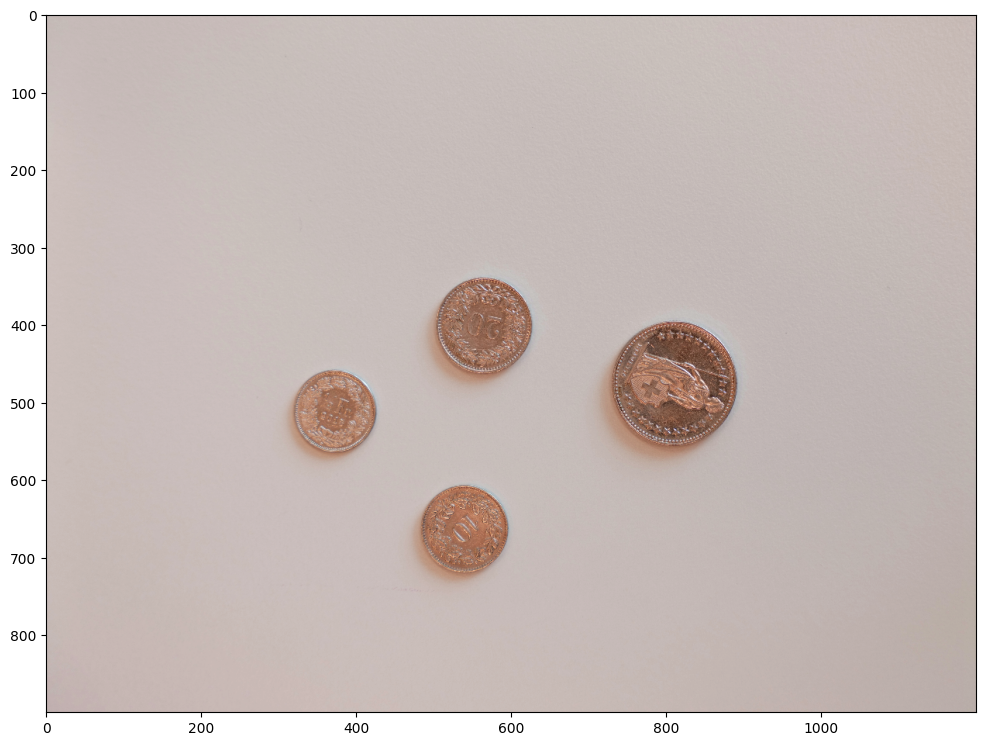

In [213]:
from scripts.config import ID_TO_LABEL
from matplotlib import pyplot as plt
from torchvision.utils import draw_bounding_boxes

pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{ID_TO_LABEL[label.item()]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="black", font='Arial', font_size=20)

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [214]:
import torchvision


def apply_nms(orig_prediction, iou_thresh=0.1):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

new_pred = apply_nms(pred)

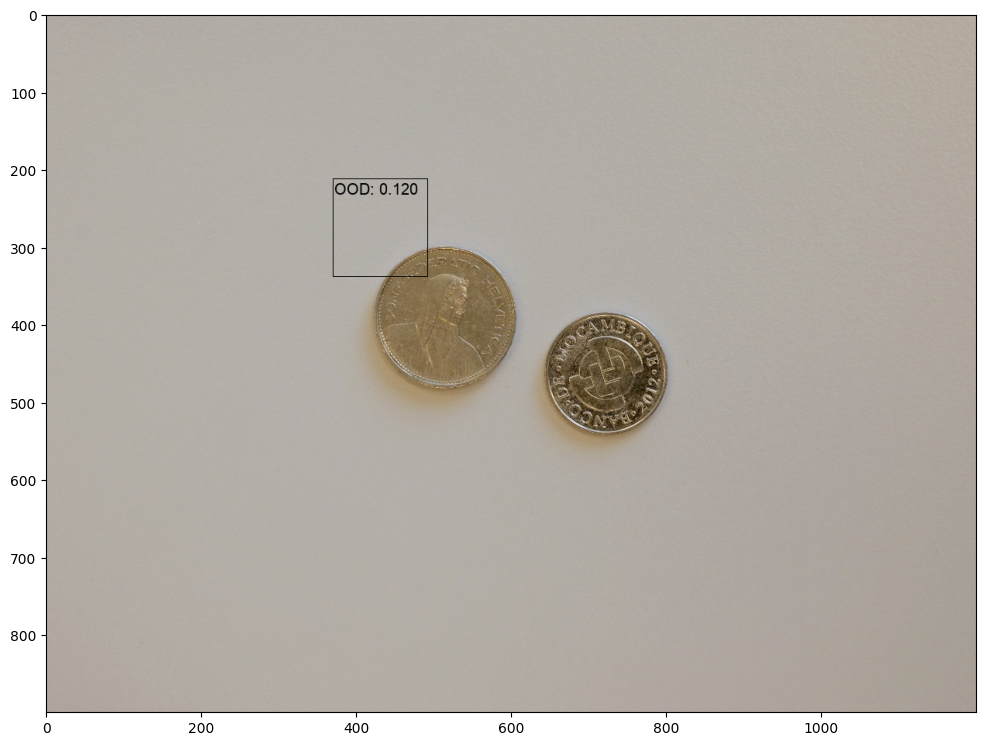

In [195]:
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{ID_TO_LABEL[label.item()]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="black", font='Arial', font_size=20)

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [166]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidu

In [ ]:
from torch import nn

test_dataset = myOwnDataset("data/test", transforms=test_tf)


def predict(model: nn.Module, dataloader: DataLoader):
    

In [ ]:
for i, (model, (image, _)) in enumerate(loaders):
    decoder, encoder = model.name.split("-", 1)
    ensembler.set_model(
        encoder, decoder
    )  # as we don't care about the model type

    image = image.to(device)

    predicted = get_prediction(model, image, kwargs["class_threshold"])
    ensembler.add_inference(predicted, str(i))

final_prediction = ensembler.get_majority_vote()

f.writelines(
    "{}\n".format(s)
    for s in _mask_to_submission_string(
        img_number, final_prediction, **kwargs
    )
)